In [8]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import re
import lightgbm as lgb
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
path = Path('../../../data/2021_evraz')

In [4]:
target_train = pd.read_pickle(path.joinpath('target_train_wo_gas_wo_sip.pkl'))
print(target_train.shape)
target_train.head(3)

(2063, 145)


NPLV   TST      C       VES       T    SI    MN      S      P    CR  ...  \
0  510008  1690  0.060  263700.0  1396.0  0.44  0.22  0.023  0.097  0.03  ...   
1  510009  1683  0.097  264500.0  1419.0  0.68  0.20  0.017  0.087  0.02  ...   
2  510010  1662  0.091  263800.0  1384.0  0.56  0.26  0.017  0.096  0.03  ...   

   plavka_TIPE_FUR_koniceskaa  plavka_TIPE_FUR_zilindriceskaa  \
0                           0                               1   
1                           0                               1   
2                           0                               1   

   plavka_TIPE_GOL_4-soplh54  plavka_TIPE_GOL_4-soplx54  \
0                          0                          0   
1                          0                          0   
2                          0                          0   

  plavka_TIPE_GOL_5soplovaa  plavka_TIPE_GOL_601-5  plavka_TIPE_GOL_E32  \
0                         1                      0                    0   
1                         1                      0                    0   
2                         1                      0                    0   

   plavka_TIPE_GOL_E37_4-soplh54  plavka_TIPE_GOL_E_4-soplh54    pol_ras_sum  
0                              0                            0  593045.405789  
1                              0                            0  567680.040137  
2                              0                            0  591476.261946  

[3 rows x 145 columns]

In [5]:
test = pd.read_pickle(path.joinpath('test_wo_gas_wo_sip.pkl'))
print(test.shape)
test.head(3)

(780, 143)


NPLV       VES       T    SI    MN      S      P    CR    NI    CU  ...  \
0  512324  240100.0  1355.0  0.46  0.33  0.027  0.079  0.01  0.01  0.02  ...   
1  512327  266400.0  1390.0  0.30  0.33  0.032  0.099  0.01  0.00  0.00  ...   
2  512328  270200.0  1373.0  0.00  0.00  0.000  0.000  0.00  0.00  0.00  ...   

   plavka_TIPE_FUR_koniceskaa  plavka_TIPE_FUR_zilindriceskaa  \
0                           0                               1   
1                           0                               1   
2                           0                               1   

  plavka_TIPE_GOL_4-soplh54  plavka_TIPE_GOL_4-soplx54  \
0                         1                          0   
1                         1                          0   
2                         1                          0   

   plavka_TIPE_GOL_5soplovaa  plavka_TIPE_GOL_601-5  plavka_TIPE_GOL_E32  \
0                          0                      0                    0   
1                          0                      0                    0   
2                          0                      0                    0   

   plavka_TIPE_GOL_E37_4-soplh54  plavka_TIPE_GOL_E_4-soplh54    pol_ras_sum  
0                              0                            0  463015.154170  
1                              0                            0  499984.992640  
2                              0                            0  468358.082766  

[3 rows x 143 columns]

Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 1648.73	train's l2: 2.7183e+06	test T's rmse: 1645.36	test T's l2: 2.70722e+06
[50]	train's rmse: 1648.73	train's l2: 2.7183e+06	test T's rmse: 1645.36	test T's l2: 2.70722e+06
[75]	train's rmse: 1648.73	train's l2: 2.7183e+06	test T's rmse: 1645.36	test T's l2: 2.70722e+06
[100]	train's rmse: 1648.73	train's l2: 2.7183e+06	test T's rmse: 1645.36	test T's l2: 2.70722e+06
[125]	train's rmse: 1648.73	train's l2: 2.7183e+06	test T's rmse: 1645.36	test T's l2: 2.70722e+06
[150]	train's rmse: 1648.73	train's l2: 2.7183e+06	test T's rmse: 1645.36	test T's l2: 2.70722e+06
[175]	train's rmse: 1648.73	train's l2: 2.7183e+06	test T's rmse: 1645.36	test T's l2: 2.70722e+06
[200]	train's rmse: 1648.73	train's l2: 2.7183e+06	test T's rmse: 1645.36	test T's l2: 2.70722e+06
[225]	train's rmse: 1648.73	train's l2: 2.7183e+06	test T's rmse: 1645.36	test T's l2: 2.70722e+06
[250]	train's rmse: 1648.73	train's l2: 2.7183e+0

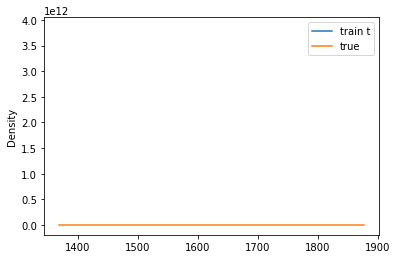


 Распределения истинных и предсказанных данных T на тесте


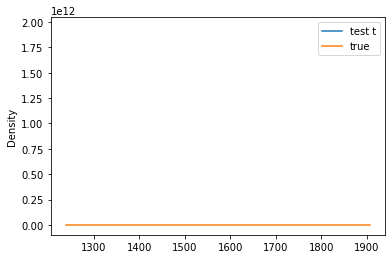


 Распределения истинных и предсказанных данных C на трейне



 Распределения истинных и предсказанных данных C на тесте


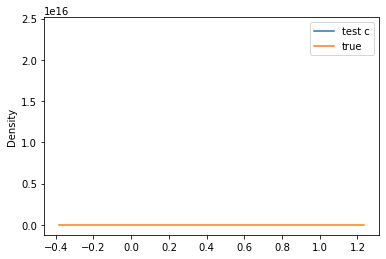

In [16]:
X_train, X_valid = train_test_split(
    target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), train_size=0.8, random_state=1)
    
y_train_t, y_valid_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)
    
y_train_c, y_valid_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_c, y_valid_true_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_t, y_valid_true_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)

lgb_params = { 
     'boosting_type': 'gbdt',
     'n_estimators': 10000,
     'learning_rate': 0.05134, # default = 0.1, constraints: learning_rate > 0.0
     'num_leaves': 10, # default = 31
     'min_data_in_leaf':10000, # default = 20
     'feature_fraction':0.1, # default = 1.0, constraints: 0.0 < feature_fraction <= 1.0
     'max_depth': 10,
     'subsample_for_bin': 240000,
     'lambda_l1': 2,
     'lambda_l2': 0,
     'colsample_bytree': 0.508716,
     'min_split_gain': 0.024766,
     'subsample': 0.7,
     'is_unbalance': False,
     'random_state': 27,
     'silent': -1,
     'verbose': -1
}

model_t = lgb.LGBMRegressor(**lgb_params)
model_c = lgb.LGBMRegressor(**lgb_params)
model_t.fit(
    X=X_train, 
    y=y_train_t,
    eval_set=[(X_train, y_train_t), (X_valid, y_valid_t)],
    eval_names=["train", "test T"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
model_c.fit(
    X=X_train, 
    y=y_train_c,
    eval_set=[(X_train, y_train_c), (X_valid, y_valid_c)],
    eval_names=["train", "test C"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
# metric from https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric
# eval_metric could be taken from: https://xgboost.readthedocs.io/en/latest/parameter.html
# or  https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

train_predictions_t, test_predictions_t = pd.DataFrame(), pd.DataFrame()
train_predictions_c, test_predictions_c = pd.DataFrame(), pd.DataFrame()

train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

# график
print('\n Распределения истинных и предсказанных данных T на трейне')
ax =  pd.Series(train_predictions_t).plot.kde(label='train t')
pd.Series(y_train_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных T на тесте')
ax =  pd.Series(test_predictions_t).plot.kde(label='test t')
pd.Series(y_valid_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на трейне')
ax =  pd.Series(train_predictions_c).plot.kde(label='train c')
pd.Series(y_train_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на тесте')
ax =  pd.Series(test_predictions_c).plot.kde(label='test c')
pd.Series(y_valid_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

In [17]:
train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

In [18]:
test_t = model_t.predict(test.drop(['DATA_ZAMERA'], axis=1))
test_c = model_c.predict(test.drop(['DATA_ZAMERA'], axis=1))

In [19]:
answers = pd.concat([pd.Series(y_valid_true_t).rename('TST'), 
                     pd.Series(y_valid_true_c).rename('C')
                   ],
                   axis=1
                  )
answers.head(2)

TST      C
1944  1684  0.037
56    1666  0.056

In [20]:
predictions = pd.concat([pd.Series(y_valid_t).rename('TST'), 
                     pd.Series(y_valid_c).rename('C')
                   ],
                   axis=1
                  )
predictions.head(2)

TST      C
1944  1684  0.037
56    1666  0.056

In [1078]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

metric(predictions, answers)

1.0

In [21]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_t).rename('TST'), 
                    pd.Series(test_c).rename('C')
                   ],
                   axis=1
                  )
submit.head(2)

NPLV          TST         C
0  512324  1648.454545  0.083631
1  512327  1648.454545  0.083631

In [22]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'lgb_predictions_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  lgb_predictions_2021-10-31_00-37-48.csv

 File saved to disk!
